# GameStop Pre-order Analysis: Solution

## Overview
This notebook demonstrates how to analyze and optimize pre-order strategies for video game retailers using probability theory and statistical analysis.

## Learning Objectives
1. Model customer pre-order behavior
2. Calculate optimal inventory levels
3. Analyze risk and uncertainty
4. Develop pricing strategies

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize

## Part 1: Pre-order Demand Modeling

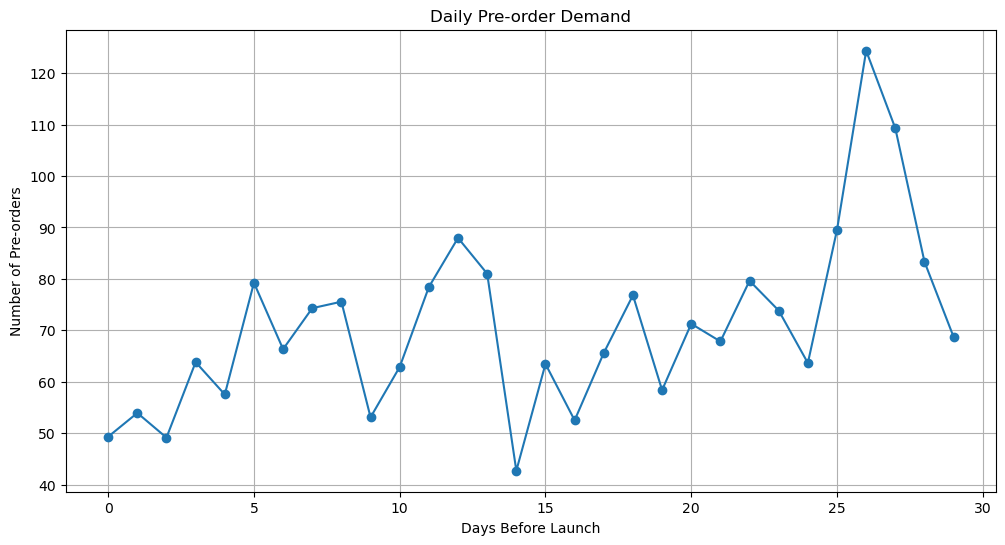

Pre-order Demand Summary:
Total Pre-orders: 2123
Average Daily Pre-orders: 70.8
Standard Deviation: 17.1


In [7]:
def generate_preorder_demand(n_days, mean_daily_orders=50, std_daily_orders=10):
    """Generate pre-order demand data with time-varying patterns"""
    # Base demand following normal distribution
    base_demand = np.random.normal(mean_daily_orders, std_daily_orders, n_days)
    
    # Add time trend (increasing as launch approaches)
    time_trend = np.linspace(0, mean_daily_orders * 0.5, n_days)
    
    # Add weekly seasonality (weekend boost)
    weekly_pattern = np.tile([1.0, 1.0, 1.0, 1.0, 1.2, 1.5, 1.3], (n_days // 7) + 1)[:n_days]
    
    # Combine components
    demand = (base_demand + time_trend) * weekly_pattern
    
    # Ensure non-negative demand
    return np.maximum(demand, 0)

# Generate example data
n_days = 30  # 30 days before launch
daily_preorders = generate_preorder_demand(n_days)

# Plot daily pre-orders
plt.figure(figsize=(12, 6))
plt.plot(daily_preorders, marker='o')
plt.title('Daily Pre-order Demand')
plt.xlabel('Days Before Launch')
plt.ylabel('Number of Pre-orders')
plt.grid(True)
plt.show()

# Calculate summary statistics
print('Pre-order Demand Summary:')
print(f'Total Pre-orders: {int(daily_preorders.sum())}')
print(f'Average Daily Pre-orders: {daily_preorders.mean():.1f}')
print(f'Standard Deviation: {daily_preorders.std():.1f}')

## Part 2: Probability Distribution Fitting

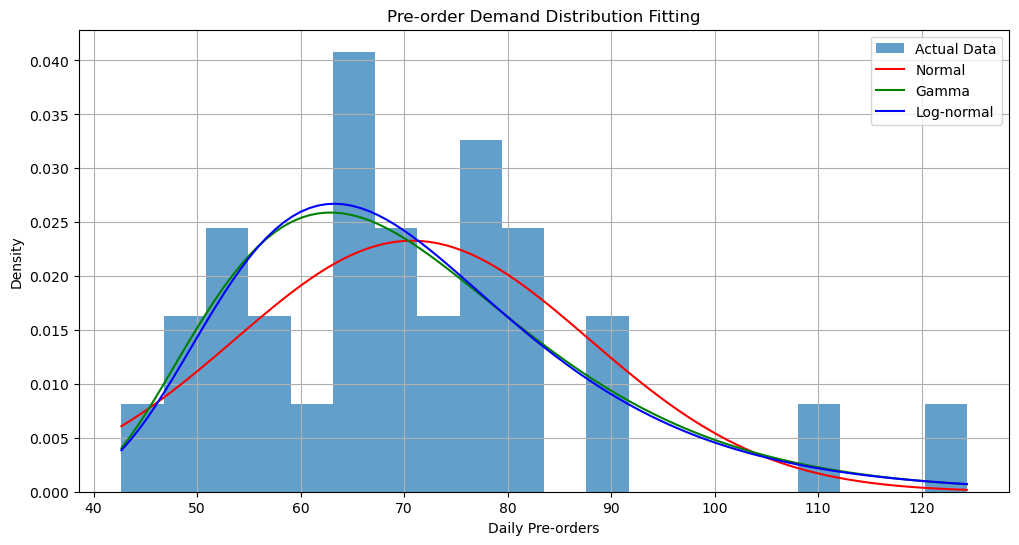


Goodness of Fit Tests (Kolmogorov-Smirnov):
Normal: p-value = 0.8345
Gamma: p-value = 0.9052
Log-normal: p-value = 0.9243


In [8]:
def fit_demand_distribution(data):
    """Fit probability distributions to pre-order demand data"""
    # Fit normal distribution
    norm_params = stats.norm.fit(data)
    
    # Fit gamma distribution
    gamma_params = stats.gamma.fit(data)
    
    # Fit lognormal distribution
    lognorm_params = stats.lognorm.fit(data)
    
    # Generate points for plotting
    x = np.linspace(data.min(), data.max(), 100)
    
    # Plot histogram and fitted distributions
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=20, density=True, alpha=0.7, label='Actual Data')
    plt.plot(x, stats.norm.pdf(x, *norm_params), 'r-', label='Normal')
    plt.plot(x, stats.gamma.pdf(x, *gamma_params), 'g-', label='Gamma')
    plt.plot(x, stats.lognorm.pdf(x, *lognorm_params), 'b-', label='Log-normal')
    plt.title('Pre-order Demand Distribution Fitting')
    plt.xlabel('Daily Pre-orders')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return norm_params, gamma_params, lognorm_params

# Fit distributions
norm_params, gamma_params, lognorm_params = fit_demand_distribution(daily_preorders)

# Perform Kolmogorov-Smirnov test for goodness of fit
print('\nGoodness of Fit Tests (Kolmogorov-Smirnov):')
print(f'Normal: p-value = {stats.kstest(daily_preorders, "norm", norm_params)[1]:.4f}')
print(f'Gamma: p-value = {stats.kstest(daily_preorders, "gamma", gamma_params)[1]:.4f}')
print(f'Log-normal: p-value = {stats.kstest(daily_preorders, "lognorm", lognorm_params)[1]:.4f}')

## Part 3: Inventory Optimization

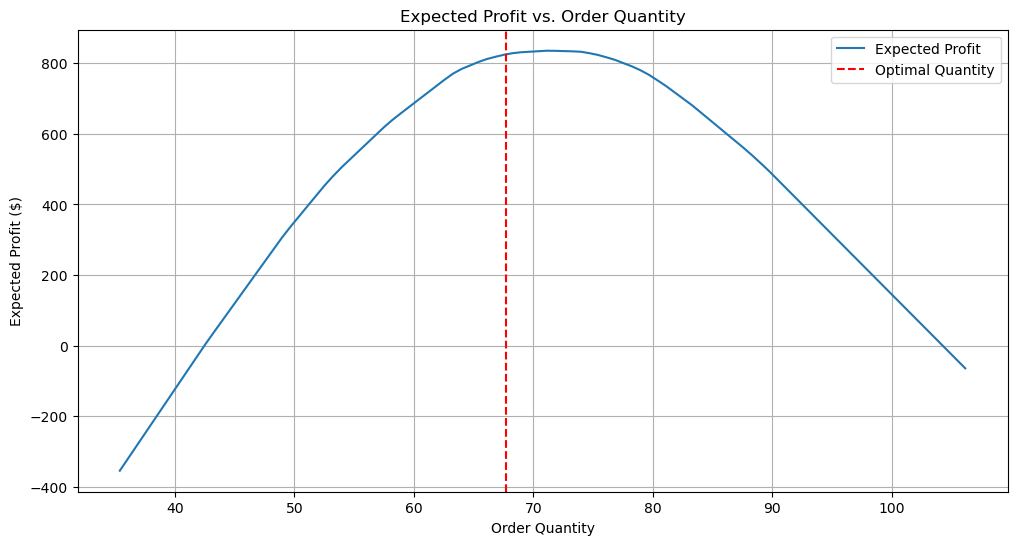


Optimal Inventory Results:
Optimal Order Quantity: 67 units
Expected Profit: $824.92


In [9]:
def calculate_optimal_inventory(demand_data, unit_cost=40, selling_price=60, shortage_cost=30):
    """Calculate optimal inventory level using newsvendor model"""
    # Calculate critical ratio
    cu = shortage_cost  # underage cost (lost profit + goodwill)
    co = unit_cost  # overage cost (holding cost)
    critical_ratio = cu / (cu + co)
    
    # Find optimal quantity using inverse CDF
    mean_demand = np.mean(demand_data)
    std_demand = np.std(demand_data)
    optimal_quantity = stats.norm.ppf(critical_ratio, mean_demand, std_demand)
    
    # Calculate expected profit
    def expected_profit(q):
        # Expected sales
        expected_sales = np.mean(np.minimum(demand_data, q))
        # Expected leftover
        expected_leftover = q - expected_sales
        # Expected shortage
        expected_shortage = np.mean(np.maximum(demand_data - q, 0))
        
        return selling_price * expected_sales - unit_cost * q - shortage_cost * expected_shortage
    
    # Calculate expected profit at optimal quantity
    optimal_profit = expected_profit(optimal_quantity)
    
    # Plot profit function
    quantities = np.linspace(mean_demand * 0.5, mean_demand * 1.5, 100)
    profits = [expected_profit(q) for q in quantities]
    
    plt.figure(figsize=(12, 6))
    plt.plot(quantities, profits, label='Expected Profit')
    plt.axvline(x=optimal_quantity, color='r', linestyle='--', label='Optimal Quantity')
    plt.title('Expected Profit vs. Order Quantity')
    plt.xlabel('Order Quantity')
    plt.ylabel('Expected Profit ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return optimal_quantity, optimal_profit

# Calculate optimal inventory
optimal_quantity, optimal_profit = calculate_optimal_inventory(daily_preorders)
print('\nOptimal Inventory Results:')
print(f'Optimal Order Quantity: {int(optimal_quantity)} units')
print(f'Expected Profit: ${optimal_profit:,.2f}')

## Part 4: Risk Analysis and Simulation

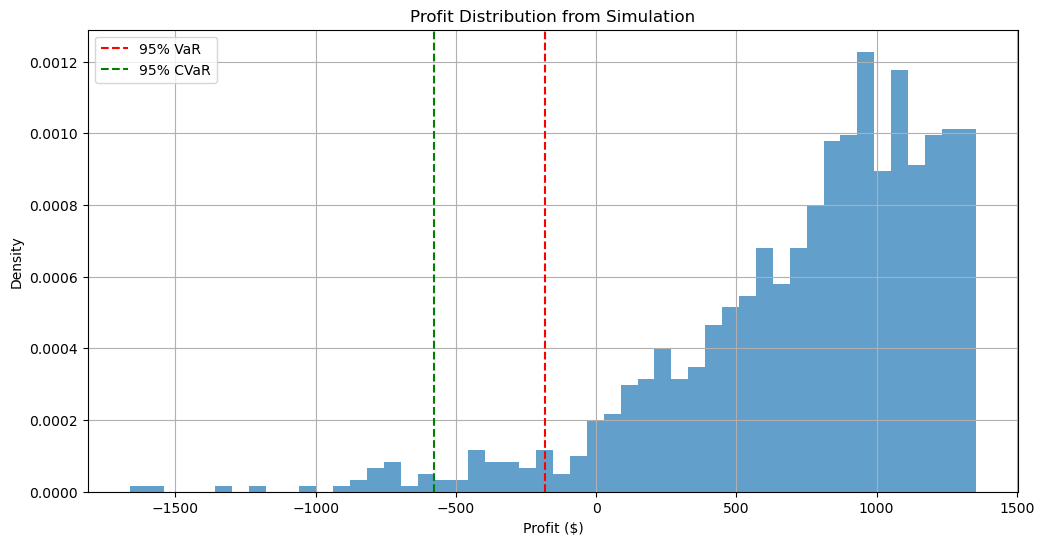


Risk Analysis Results:
95% Value at Risk: $180.44
95% Conditional VaR: $576.73


In [10]:
def simulate_scenarios(demand_params, n_simulations=1000):
    """Simulate different demand scenarios and analyze risk"""
    mean_demand, std_demand = demand_params
    
    # Generate random demand scenarios
    simulated_demand = np.random.normal(mean_demand, std_demand, n_simulations)
    simulated_demand = np.maximum(simulated_demand, 0)  # Ensure non-negative demand
    
    # Calculate profit for each scenario
    def calculate_profit(demand, quantity):
        sales = min(demand, quantity)
        leftover = max(0, quantity - sales)
        shortage = max(0, demand - quantity)
        return 60 * sales - 40 * quantity - 30 * shortage
    
    profits = [calculate_profit(d, optimal_quantity) for d in simulated_demand]
    
    # Calculate risk metrics
    var_95 = np.percentile(profits, 5)  # 95% Value at Risk
    cvar_95 = np.mean([p for p in profits if p <= var_95])  # Conditional VaR
    
    # Plot profit distribution
    plt.figure(figsize=(12, 6))
    plt.hist(profits, bins=50, density=True, alpha=0.7)
    plt.axvline(x=var_95, color='r', linestyle='--', label='95% VaR')
    plt.axvline(x=cvar_95, color='g', linestyle='--', label='95% CVaR')
    plt.title('Profit Distribution from Simulation')
    plt.xlabel('Profit ($)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return var_95, cvar_95

# Run simulation
var_95, cvar_95 = simulate_scenarios((np.mean(daily_preorders), np.std(daily_preorders)))

print('\nRisk Analysis Results:')
print(f'95% Value at Risk: ${-var_95:,.2f}')
print(f'95% Conditional VaR: ${-cvar_95:,.2f}')